In [112]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, math, random
import simplejson as json
import requests
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
import csv
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

# Classify User Politics at Beginning of Experiment

In [123]:
experiment_start = parser.parse("2017-07-31 07:03:51")
experiment_end = parser.parse("2017-09-07 07:00:12")

### Load Politics Subreddits
Based on https://www.reddit.com/r/politics/wiki/relatedsubs

Sampled Oct 29, 2017

With one addition: uncensorednews

In [172]:
spreadsheet_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQMSxnq4r12fzPwiYd8DtKzdubaF1si52GFHjujDmIQGAnXYGTVJPIOClcNjbqVurZ5FjtjP9hlbHB4/pub?output=csv"
response = requests.get(spreadsheet_url)
lines = None
if(response.status_code == 200):
    lines = response.text.split("\r\n")
subreddits = {}
headers = {}
i = 0
for key in lines[0].split(","):
    headers[i] = key
    i+=1
print("Headers: {0}".format(headers))
for line in lines[1:]:
    linedict = {}
    i = 0
    for value in line.split(","):
        if(i==0):
            linedict[headers[i]] = value.lower()
        elif(value==''):
            linedict[headers[i]] = 0
        else:
            linedict[headers[i]] = 1

        i+=1
    subreddits[linedict['Subreddit']] = linedict

Headers: {0: 'Subreddit', 1: 'Left', 2: 'Right'}


### Load Subreddits Similar to The_Donald 
According to Subreddit Algebra (sigh) https://trevor.shinyapps.io/subalgebra/
Queried on Oct 31, 2017. Chose all subreddits that listed an 0.6 or higher similarity score, excluding r/politics and r/news

In [174]:
like_the_donald = ['conservative', 'asktrumpsupporters', 'hillaryforprison', 'uncensorednews', 'askthe_donald', 'libertarian', 'mr_trump', 'conspiracy']

In [175]:
for subreddit in like_the_donald:
    if subreddit not in subreddits.keys():
        print("{0} not in politics subreddits".format(subreddit))

# Assign Politics Participation History to Comments

### Identify users in the experiment

In [ ]:
experiment_users = set()
for row in db_engine.execute(text("""\
SELECT * FROM comments WHERE subreddit_id='2cneq' AND created_at >= '{0}' AND created_at < '{1}'
""".format(
            experiment_start.isoformat(), 
            experiment_end.isoformat()
        ))):
    comment = json.loads(dict(row)['comment_data'])
    experiment_users.add(comment['author'])

### Set up User Objects

In [177]:
def user():
    return {
        "author":None,
        "left.observations":0,
        "right.observations":0,
        "donald.observations":0,
        "politics.observations":0,
        "item.observations":0
    }

user_politics = defaultdict(user)

### Process Comments and Posts from Jan 1, 2017

In [146]:
all_filenames = []
for filename in glob.glob("/home/nathan/reddit_archive/03.2017/posts/*.2017.*.json"):
    f = os.path.basename(filename)
    f_str = f.split(".")
    month = f_str[2]
    year = f_str[3]
    if(year=='2017' and int(month)<=7):
        all_filenames.append(filename)
        
for filename in glob.glob("/home/nathan/reddit_archive/03.2017/*.2017.*.json"):
    f = os.path.basename(filename)
    f_str = f.split(".")
    month = f_str[2]
    year = f_str[3]
    if(year=='2017' and int(month)<=7):
        all_filenames.append(filename)
        

In [178]:
i = 0
for filename in all_filenames:
    file = open(filename, "r")
    for line in file:
        item = json.loads(line)
#        item_date = datetime.datetime.fromtimestamp(float(item['created_utc']))
#        if(item_date > experiment_start):
#            continue
        ## WE COUNT ALL ACTIONS IN OR OUT OF SUBS
        author = item['author']
        if(author=='[deleted]' or author not in experiment_users):
            continue
        itemuser = user_politics[author]
        itemuser['item.observations'] +=1
        if('subreddit_id' in item):
            subreddit = item['subreddit'].lower()
            itemuser['author'] = author
            if(subreddit in subreddits.keys()):
                itemuser['politics.observations'] += 1
                sub_leaning = subreddits[subreddit]
                itemuser['left.observations'] += sub_leaning['Left']
                itemuser['right.observations'] += sub_leaning['Right']
            if subreddit in like_the_donald:
                itemuser['donald.observations'] += 1 
    sys.stdout.write(".")
    sys.stdout.flush()
    i+=1
    if(i%10==0):
        print("\n")

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

..........

......

In [179]:
for user in user_politics.values():
    user['pct.politics'] = user['politics.observations']  / user['item.observations']
    user['pct.donald'] = None
    user['pct.left'] = None
    user['pct.right'] = None
    if(user['politics.observations']>0):
        user['pct.donald'] = user['donald.observations']  / user['politics.observations']
        user['pct.left'] = user['left.observations']  / user['politics.observations']
        user['pct.right'] = user['right.observations']  / user['politics.observations']

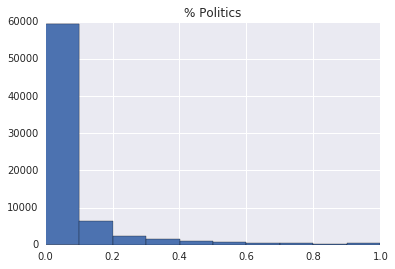

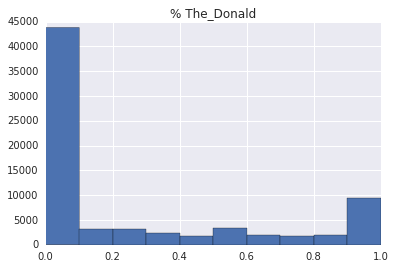

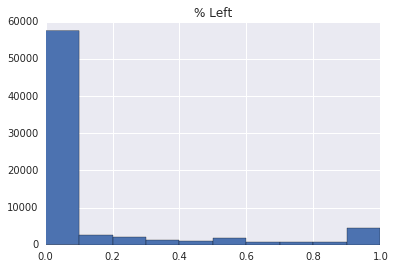

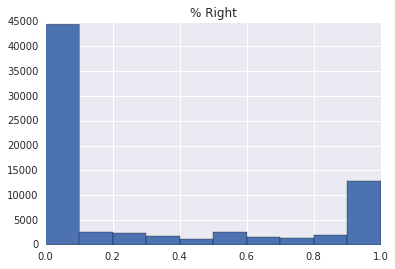

In [184]:
plt.hist([x['pct.politics'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Politics")
plt.show()
plt.hist([x['pct.donald'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% The_Donald")
plt.show()
plt.hist([x['pct.left'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Left")
plt.show()
plt.hist([x['pct.right'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Right")
plt.show()

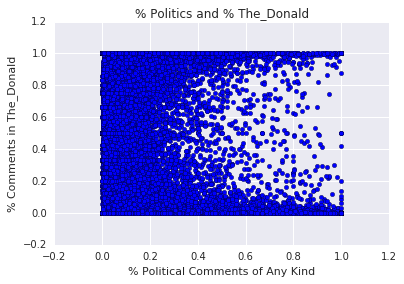

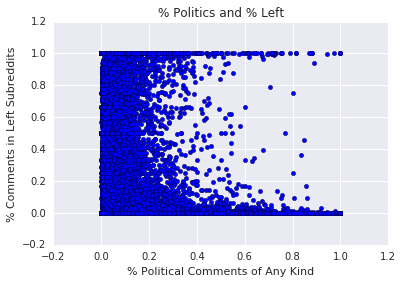

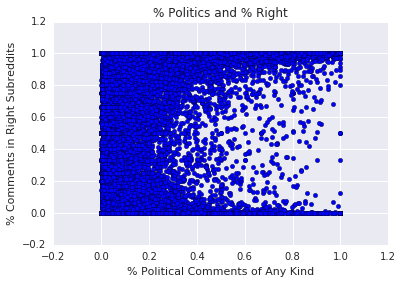

In [188]:
plt.scatter([x['pct.politics'] for x in user_politics.values() if x['politics.observations']>0],
           [x['pct.donald'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Politics and % The_Donald")
plt.xlabel('% Political Comments of Any Kind')
plt.ylabel('% Comments in The_Donald')
plt.show()

plt.scatter([x['pct.politics'] for x in user_politics.values() if x['politics.observations']>0],
           [x['pct.left'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Politics and % Left")
plt.xlabel('% Political Comments of Any Kind')
plt.ylabel('% Comments in Left Subreddits')
plt.show()

plt.scatter([x['pct.politics'] for x in user_politics.values() if x['politics.observations']>0],
           [x['pct.right'] for x in user_politics.values() if x['politics.observations']>0])
plt.title("% Politics and % Right")
plt.xlabel('% Political Comments of Any Kind')
plt.ylabel('% Comments in Right Subreddits')
plt.show()

In [183]:
pd.DataFrame(list(user_politics.values())).to_csv("outputs/user_politics-2017.01-07_2017.11.csv")

In [189]:
subreddits.keys()

dict_keys(['jillstein', 'politicalfactchecking', 'greenparty', 'tedcruz', 'savetheconstitution', 'cornbreadliberals', 'mr_trump', 'voting', 'politicaltweets', 'objectivism', 'classical_liberals', 'askthe_donald', 'gunpolitics', 'republicofpolitics', '2016_elections', 'masspolitics', 'politic', 'descentintotyranny', 'humanrights', 'thirdpartyroundtable', 'mcmullin', 'the_donald', 'truepolitics', 'usanews', 'politicsdebate', 'ronpaul', 'uncensorednews', 'americangovernment', 'libertariansocialism', 'politicalphilosophy', 'worldunity', 'conspiratard', 'pirateparty', 'americanselect', 'truelibertarian', 'bencarson', 'electionreform', 'environment', 'peoplesparty', 'socialism', 'communism', 'anarchy101', 'doctorswithoutborders', 'anarcho_capitalism', 'anarchism', 'bullmooseparty', 'libertarianwomen', 'debatecommunism', 'labor', 'ask_politics', 'socialdemocracy', 'gunsarecool', 'wealth', 'utahpolitics', 'anarchistnews', 'moderatepolitics', 'liberty', 'demsocialist', 'jindal', 'rvbdebates', '

In [190]:
list(user_politics.values())[0]

{'author': 'Blitzpull',
 'donald.observations': 0,
 'item.observations': 274,
 'left.observations': 0,
 'pct.donald': 0.0,
 'pct.left': 0.0,
 'pct.politics': 0.021897810218978103,
 'pct.right': 0.0,
 'politics.observations': 6,
 'right.observations': 0}